## Project Info 

* This notebook aims at analyzing the content of an E-commerce database that lists purchases made by  ∼ 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.

* Customer segmentation is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors, including: demographics (age, gender, location etc), behaviour (previous orders, responses to messaging), psychographics (values, interests, lifestyles) etc.

* RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

* The goal of this analysis is to identify customer segments for global retail company using RFM analysis and to understand how those groups differ from each other.

# Data Preperation 

### Step 1: Import libraries

In [1]:
import pandas as pd
import numpy as np 
import time
import datetime as dt

import re

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score




import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

start = time.time()

In [2]:
df = pd.read_csv('rfm_data.csv', encoding = 'unicode_escape', dtype = {'CustomerID' : str})

# The first five rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
# The last five rows 

df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,12/9/2011 12:50,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,12/9/2011 12:50,4.95,12680,France


# Data Explorations:

### Columns Description

* InvoiceNo : Unique ID for every time a consumer visits the store
* StockCode: Unique ID for a product
* Description : Description of the product
* Quantity : No of units bought
* InvoiceDate : Date and time of purchase
* Unit Price : Price for 1 unit of the product
* CustomerId : Unique ID for each customer
* Country : Country where transaction happened

### Let's understand the columns names first, before we move on 

In [4]:
print('The names of each column are below: \n')

i = 0 
for column_name in df.columns:
    i += 1
    print(f'{i}.', column_name)

The names of each column are below: 

1. InvoiceNo
2. StockCode
3. Description
4. Quantity
5. InvoiceDate
6. UnitPrice
7. CustomerID
8. Country


In [5]:
# I will change the names or the first letters of some columns in order to make it easy as i type

df.rename(index = str , 
          columns = {'InvoiceNo': 'invoice_num',
                    'StockCode' : 'stock_code',
                    'Description' : 'description',
                    'Quantity' : 'quantity',
                    'InvoiceDate' : 'invoice_date',
                    'UnitPrice' : 'unit_price',
                    'CustomerID' : 'customer_id',
                    'Country' : 'country'}, inplace=True)

In [6]:
# The data has 541909 entries and 8 variables before we make any adjustment
# After loading data set, we are trying to get general information about our dataset.

print('The shape of our dataset before we make any adjustment is', df.shape)

The shape of our dataset before we make any adjustment is (541909, 8)


In [7]:
print('Some info about our dataset is below: \n')

df.info()

Some info about our dataset is below: 

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_num   541909 non-null  object 
 1   stock_code    535874 non-null  object 
 2   description   534420 non-null  object 
 3   quantity      535874 non-null  float64
 4   invoice_date  535874 non-null  object 
 5   unit_price    535874 non-null  float64
 6   customer_id   403182 non-null  object 
 7   country       535874 non-null  object 
dtypes: float64(2), object(6)
memory usage: 37.2+ MB


In [8]:
print('Here are info about the type of each column: \n')

df.dtypes

Here are info about the type of each column: 



invoice_num      object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id      object
country          object
dtype: object

# Step 2: Data Cleaning 

### Dealing with the missing data

In [9]:
# One way in order to check for missing values 
# Unfortunately we have

df.isnull().values.any()

True

In [10]:
# As we can see we have a lot of missing data in this dataset
# However some of them is not really important, so we don't have problem so far

print('Here we can view the missing data in our dataset: \n')

df.isnull().sum()

Here we can view the missing data in our dataset: 



invoice_num          0
stock_code        6035
description       7489
quantity          6035
invoice_date      6035
unit_price        6035
customer_id     138727
country           6035
dtype: int64

In [11]:
print('Here we can view the percentage of the missing data in our dataset: \n')

missing_percentage = (( df.isnull().sum() / df.shape[0] ) * 100).round(2)
missing_percentage

Here we can view the percentage of the missing data in our dataset: 



invoice_num      0.00
stock_code       1.11
description      1.38
quantity         1.11
invoice_date     1.11
unit_price       1.11
customer_id     25.60
country          1.11
dtype: float64

* As we can see above almost the 26% of the customers are unknown!
* Moreover, we have 1.1% of the other columns missing
* We have to dig deaper in order to understand more our dataset

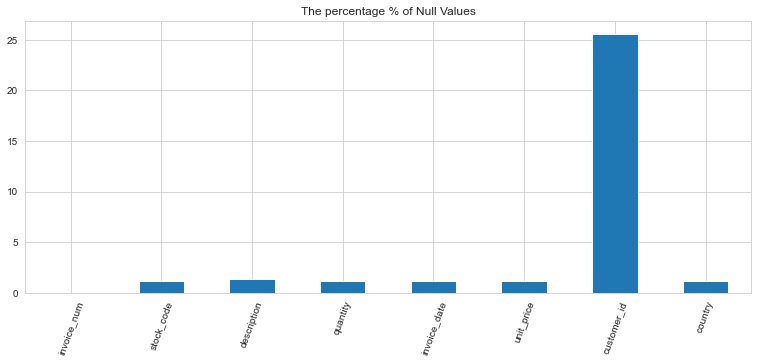

In [12]:
fig,ax = plt.subplots( figsize=(13,5))
((df.isnull().sum() / len(df))*100).plot.bar(ax=ax,rot= 70)
ax.set_title('The percentage % of Null Values')
plt.show()

In [13]:
# Droping rows having missing values

df.dropna(inplace=True)

print('Missing Values after the cleaning: {}'.format(df.isnull().sum().sum()))

Missing Values after the cleaning: 0


In [14]:
#Double check it, just in case

df.isnull().sum()

invoice_num     0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### Checking for duplicate rows 

In [15]:
duplicates_rows = df[df.duplicated()].value_counts().sum()
print('The total amount of duplicates rows are' , duplicates_rows)

The total amount of duplicates rows are 5179


In [16]:
# View the duplicate rows 
# For example, the rows 598, 601, 604 are the same as we can se notice

df[df.duplicated()].head(20)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1.0,12/1/2010 11:49,2.95,17920,United Kingdom
587,536412,22273,FELTCRAFT DOLL MOLLY,1.0,12/1/2010 11:49,2.95,17920,United Kingdom
589,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1.0,12/1/2010 11:49,3.75,17920,United Kingdom
594,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1.0,12/1/2010 11:49,2.10,17920,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920,United Kingdom
600,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2.0,12/1/2010 11:49,3.75,17920,United Kingdom


In [17]:
# Deal with the duplicates in this kernel 
# If you check the first shape we had many duplicates 
# First we had 541909 and now 398003

df.drop_duplicates(inplace = True, keep = 'first')
df.shape

(398003, 8)

In [18]:
duplicate_rows_new = df[df.duplicated()].value_counts().sum()
print('The total amount of duplicates rows after the cleaning are' , duplicate_rows_new)

The total amount of duplicates rows after the cleaning are 0


# Step 3: Time

In [19]:
# Change the format of the invoice_date 

df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_date'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: invoice_date, dtype: datetime64[ns]

In [20]:
print("The datafile starts with timepoint {} \n".format(df['invoice_date'].min()))


print("The datafile ends with timepoint {}".format((df['invoice_date'].max())))

The datafile starts with timepoint 2010-12-01 08:26:00 

The datafile ends with timepoint 2011-12-09 12:50:00


In [21]:
last_date = df['invoice_date'].min()
present_date = df['invoice_date'].max()
print('The most present date is', present_date)

The most present date is 2011-12-09 12:50:00


In [22]:
# Because of the dt.strftime and the to_datetime the type of the invoice_date changed twiced and here i make sure it's the right one

df.dtypes

invoice_num             object
stock_code              object
description             object
quantity               float64
invoice_date    datetime64[ns]
unit_price             float64
customer_id             object
country                 object
dtype: object

# Explore the data 

* After we cleaned the dataset we must dig deeper into this 

### Countries

In [23]:
# If you are worry about the last country, it's just the Republic of South Africa (RSA) and EIRE is just the Republic of Ireland

print('Below are the unique name of the countries: \n')

df['country'].value_counts().reset_index()

Below are the unique name of the countries: 



,index,country
0,United Kingdom,353400
1,Germany,9433
2,France,8443
3,EIRE,7419
4,Spain,2508
5,Netherlands,2355
6,Belgium,2060
7,Switzerland,1866
8,Portugal,1466
9,Australia,1250


In [24]:
print('In general the total numbers of the countries are:' , len(df['country'].unique()))

In general the total numbers of the countries are: 37


In [25]:
# How many customers per country 

country_df = df[['country' , 'customer_id']]
country_df.groupby(['country']).agg({'customer_id' : 'count'}).sort_values('customer_id', ascending = False).reset_index()

,country,customer_id
0,United Kingdom,353400
1,Germany,9433
2,France,8443
3,EIRE,7419
4,Spain,2508
5,Netherlands,2355
6,Belgium,2060
7,Switzerland,1866
8,Portugal,1466
9,Australia,1250


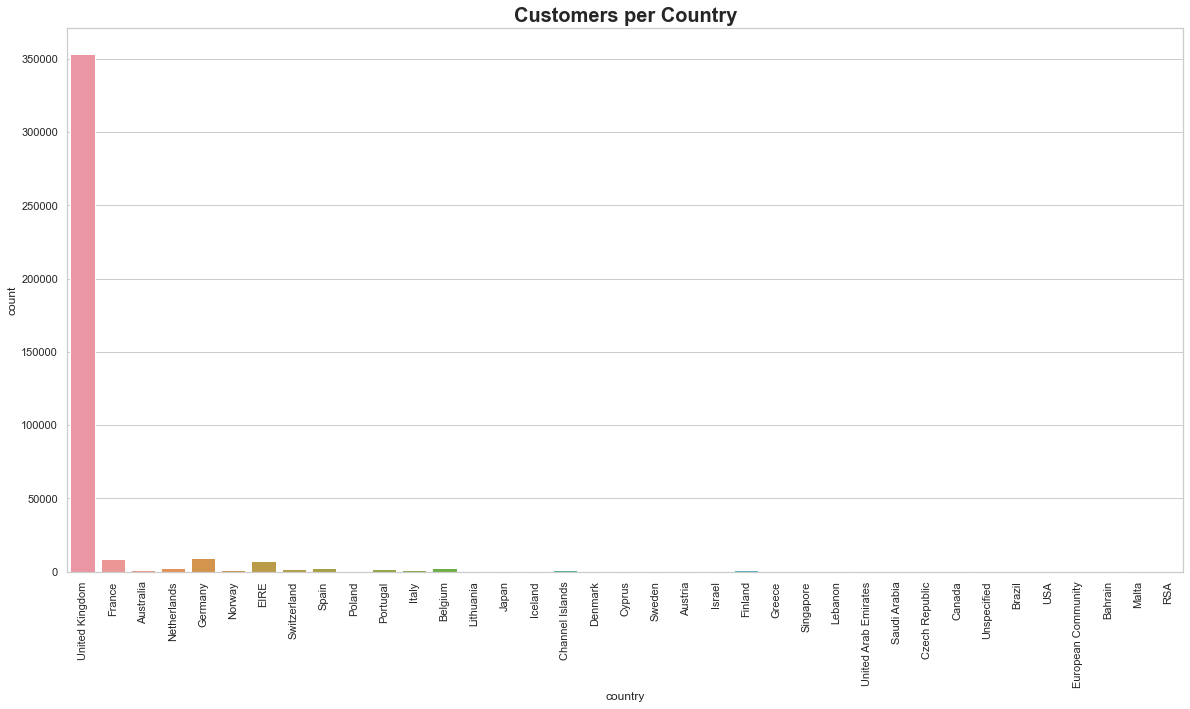

In [26]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig = plt.subplots(figsize=(20, 10))

#plot count of each RFM segment
sns.countplot(x="country", data=country_df).set_title('Customers per Country', weight = 'bold').set_fontsize('20')
plt.xticks(rotation=90)

plt.show()

In [27]:
# Now we will look at the details of the countries through which most of the orders were placed

df[['invoice_num','country']].groupby('country').count().sort_values("invoice_num",ascending = False).reset_index()

,country,invoice_num
0,United Kingdom,353400
1,Germany,9433
2,France,8443
3,EIRE,7419
4,Spain,2508
5,Netherlands,2355
6,Belgium,2060
7,Switzerland,1866
8,Portugal,1466
9,Australia,1250


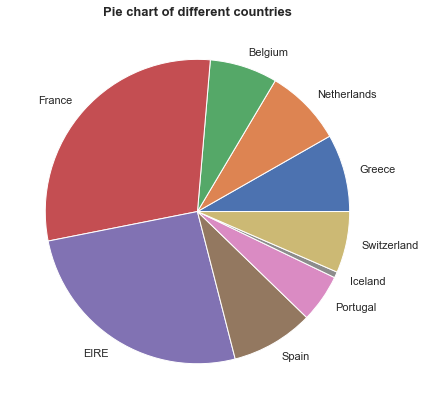

In [28]:
# Creating a Pie Chart to Visualize the the data better

# Creating dataset 
country = ['Greece','Netherlands', 'Belgium', 'France' , 'EIRE', 'Spain' , 'Portugal', 'Iceland','Switzerland']
invoice = [2363,2355, 2060, 8443 ,7419 ,2508 ,1466,181,1866]

# Creating plot 
fig = plt.figure(figsize =(10, 7)) 
plt.pie(invoice, labels = country)

# Set a title
plt.title('Pie chart of different countries', weight = 'bold').set_fontsize('13')  

# show plot 
plt.show() 

In [29]:
df.describe().round(2)

,quantity,unit_price
count,398003.00,398003.00
mean,12.16,3.49
std,173.84,70.08
min,-74215.00,0.00
25%,2.00,1.25
50%,5.00,1.95
75%,12.00,3.75
max,74215.00,38970.00


In [30]:
# How many unique product are there?

for col in df.columns:
    print(f'{col}: {df[col].nunique()} items')

invoice_num: 22161 items
stock_code: 3603 items
description: 3792 items
quantity: 434 items
invoice_date: 20433 items
unit_price: 618 items
customer_id: 4370 items
country: 37 items


In [31]:
# How many of each product are there?

df['stock_code'].value_counts().head(10)

85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
20725     1346
22720     1224
POST      1196
22197     1110
23203     1108
Name: stock_code, dtype: int64

In [32]:
# But what kinf of products are these ? 

print('Below are the top five items we have: \n')

most_stock_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=False)
most_stock_item.head()

Below are the top five items we have: 



stock_code  description                       
85123A      WHITE HANGING HEART T-LIGHT HOLDER    2058
22423       REGENCY CAKESTAND 3 TIER              1894
85099B      JUMBO BAG RED RETROSPOT               1659
47566       PARTY BUNTING                         1409
84879       ASSORTED COLOUR BIRD ORNAMENT         1405
Name: description, dtype: int64

In [33]:
# But what kinf of products are these ? 

print('Below are the last five items we have: \n')

most_stock_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=True)
most_stock_item.head()

Below are the last five items we have: 



stock_code  description                    
84877A      PINK ROUND COMPACT MIRROR          1
90165B      WHITE ROSEBUD  PEARL EARRINGS      1
84569C      PACK 4 FLOWER/BUTTERFLY PATCHES    1
90167       BEADED LOVE HEART JEWELLERY SET    1
84551       CROCHET DOG KEYRING                1
Name: description, dtype: int64

In [34]:
# Sort the 5 most ordered products from most to least.

print('The most wanted items in the dataset are \n')

df.groupby('description')['quantity'].sum().sort_values(ascending = False).head(20).astype(int)

The most wanted items in the dataset are 



description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53119
JUMBO BAG RED RETROSPOT               44963
ASSORTED COLOUR BIRD ORNAMENT         35215
WHITE HANGING HEART T-LIGHT HOLDER    34128
PACK OF 72 RETROSPOT CAKE CASES       33386
POPCORN HOLDER                        30492
RABBIT NIGHT LIGHT                    27045
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25305
PACK OF 60 PINK PAISLEY CAKE CASES    24129
BROCADE RING PURSE                    22924
VICTORIAN GLASS HANGING T-LIGHT       21955
ASSORTED COLOURS SILK FAN             21132
RED  HARMONICA IN BOX                 20882
JUMBO BAG PINK POLKADOT               19692
SMALL POPCORN HOLDER                  18197
60 TEATIME FAIRY CAKE CASES           17514
LUNCH BAG RED RETROSPOT               17024
HEART OF WICKER SMALL                 16633
JUMBO BAG STRAWBERRY                  16521
Name: quantity, dtype: int32

In [35]:
# Sort the 5 not most ordered products from most to least.
# The negative values maybe it's a problem in the dataset or the products were not delived at all 

print('The most not wanted items in the dataset are \n')

df.groupby('description')['quantity'].sum().sort_values(ascending = False).tail(20).astype(int)

The most not wanted items in the dataset are 



description
SMALL TAHITI BEACH BAG                   -1
TEA TIME CAKE STAND IN GIFT BOX          -1
WOOLLY HAT SOCK GLOVE ADVENT STRING      -1
BLUE FLYING SINGING CANARY               -1
3 WICK CHRISTMAS BRIAR CANDLE            -2
ANTIQUE LILY FAIRY LIGHTS                -3
CREAM SWEETHEART MAGAZINE RACK           -3
PINK SMALL GLASS CAKE STAND              -3
PINK CHERRY LIGHTS                       -4
CHALKBOARD KITCHEN ORGANISER             -4
BLUE PADDED SOFT MOBILE                  -6
VINTAGE GOLD TINSEL REEL                 -6
WOODEN BOX ADVENT CALENDAR               -6
WHITE CHERRY LIGHTS                      -8
ROBIN CHRISTMAS CARD                     -9
PINK POODLE HANGING DECORATION          -12
CRUK Commission                         -16
ASSORTED TUTTI FRUTTI ROUND BOX         -24
Discount                              -1194
ROTATING SILVER ANGELS T-LIGHT HLDR   -1475
Name: quantity, dtype: int32

### Stock code 

In [36]:
# View all the stock code of the dataset 

list_special_codes = df[df['stock_code'].str.contains('^[a-zA-Z]+', regex=True)]['stock_code'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [37]:
for code in list_special_codes:
    print("{:<15} ->  {:<30}".format(code, df[df['stock_code'] == code]['description'].unique()[0]))

POST            ->  POSTAGE                       
D               ->  Discount                      
C2              ->  CARRIAGE                      
M               ->  Manual                        
BANK CHARGES    ->  Bank Charges                  
PADS            ->  PADS TO MATCH ALL CUSHIONS    
DOT             ->  DOTCOM POSTAGE                
CRUK            ->  CRUK Commission               


### Cancelled Orders & Quantity

In [38]:
# The number of canceled orders 
# In the data description we can find that a cancelled transactions starts with a "C" in front of it. 
# Let's create a feature to easily filter out these cases:

canceled = (df["invoice_num"].str.contains("C", na=False)).sum()

print('The total number of items that was canceled are', canceled)

The total number of items that was canceled are 8807


In [39]:
per_canceled = ((canceled / df.shape[0]) * 100 ).round(2)

print('The percentage of canceled orders is ',per_canceled , '%')

The percentage of canceled orders is  2.21 %


In [40]:
# I am checking if there is negative quantity in tha data 
# Unluckily we have at least one 

flag = False
if (df['quantity'] < 0).any(): 
    flag = True
    print(flag)

True


In [41]:
df['canceled'] = df['invoice_num'].apply(lambda x : 'Yes' if x[0] == 'C' else 'No')

In [42]:
# There is negative quantity in the dataset. Let's check it
# Obviously there are negative quantity 

negative_quantity = df[df['quantity'] < 0]
negative_quantity.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,canceled
141,C536379,D,Discount,-1.0,2010-12-01 09:41:00,27.50,14527,United Kingdom,Yes
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1.0,2010-12-01 09:49:00,4.65,15311,United Kingdom,Yes
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12.0,2010-12-01 10:24:00,1.65,17548,United Kingdom,Yes
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24.0,2010-12-01 10:24:00,0.29,17548,United Kingdom,Yes
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24.0,2010-12-01 10:24:00,0.29,17548,United Kingdom,Yes


In [43]:
print('The total number of items that was canceled are',negative_quantity.value_counts().sum() ) 

The total number of items that was canceled are 8807


In [44]:
# I just drop the rows with the negative quantity 
# To use and statements inside a data-frame you just have to use a single & character 
# and separate each condition with parenthesis. (Link above in Stackoverflow)

df = df[df['quantity'] > 0]
df.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,No
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,No
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,No
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,No
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,No


In [45]:
# The shape of our dataset just got even smaller after the drop 

df.shape

(389196, 9)

# Calculation of RFM metrics

* Recency : the number of days between today_date and the last purchase date of this customer

* Frequency : the number of purchase of this customer

* Monetary : sum of TotalPrice of this customer

In [46]:
# I create a new column here 

df["total_price"] = df["quantity"] * df["unit_price"]

In [47]:
df.sort_values('total_price', ascending=False).head().reset_index()

,index,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,canceled,total_price
0,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,2011-01-18 10:01:00,1.04,12346,United Kingdom,No,77183.60
1,222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60.0,2011-06-10 15:28:00,649.50,15098,United Kingdom,No,38970.00
2,173382,551697,POST,POSTAGE,1.0,2011-05-03 13:46:00,8142.75,16029,United Kingdom,No,8142.75
3,348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412.0,2011-09-20 11:05:00,5.06,17450,United Kingdom,No,7144.72
4,52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114.0,2011-01-11 12:55:00,2.10,15749,United Kingdom,No,6539.40


In [48]:
#No. of products sold by Country

products_country = df.groupby('country').count()['total_price'].sort_values(ascending=False).head(10)
products_country

country
United Kingdom    345957
Germany             8983
France              8295
EIRE                7173
Spain               2460
Netherlands         2347
Belgium             2022
Switzerland         1831
Portugal            1448
Australia           1176
Name: total_price, dtype: int64

In [49]:
#No. of products sold by Country

products_country = df.groupby('country').count()['total_price'].sort_values(ascending=False).tail(10)
products_country

country
Malta                   111
United Arab Emirates     67
European Community       60
RSA                      58
Lebanon                  45
Lithuania                35
Brazil                   32
Czech Republic           25
Bahrain                  17
Saudi Arabia              9
Name: total_price, dtype: int64

In [50]:
present = dt.date(2011,12,9)

#### Create the RFM Table

In [51]:
#new_df = df[['quantity' , 'unit_price', 'total_price']]
#new_df.head()

In [52]:
# Aggregate at customer level
#customer_df = pd.DataFrame(df.pivot_table(index="customer_id", 
                                            
                                              #values=["invoice_date", "total_price"], 
                                            
                                              #aggfunc={"invoice_date": [min, max, pd.Series.nunique], "total_price": sum}))
#customer_df.head()

In [53]:
#customer_df.columns = ["LastInvoiceDate", "FirstInvoiceDate", "Frequency", "MonetaryValue"]
#customer_df.head().reset_index()

In [54]:
today_date = dt.datetime(2011,12,11)

In [55]:
rfm = df.groupby('customer_id').agg({'invoice_date' : lambda invoice_date:  (today_date - invoice_date.max()).days,
                                    'invoice_num'   : lambda invoice_num:   invoice_num.nunique(),
                                    'total_price'   : lambda total_price:   total_price.sum()})

In [56]:
rfm.columns = ['recency','frequency','monetary']
rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()
rfm.head()

,customer_id,recency,frequency,monetary
0,12346,326,1,326.0
1,12347,3,7,3.0
2,12348,76,4,76.0
3,12349,19,1,19.0
4,12350,311,1,311.0


<AxesSubplot:>

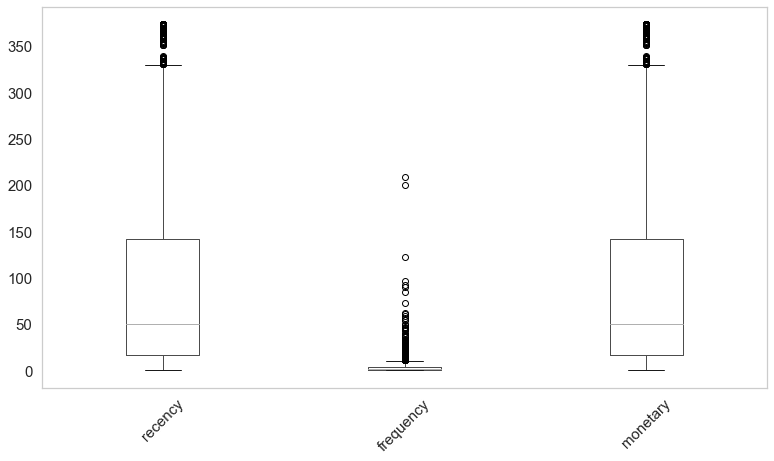

In [57]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(13, 7))

rfm.boxplot(grid=False, rot=45, fontsize=15)

In [58]:
# Fing top 10 customers based on frequency and monetary values
# Sorting first on frequency and then on Monetary value¶
# Below are top ten customers after sorting¶

rfm.sort_values(['frequency', 'monetary'], ascending=[False, False], inplace=True)
rfm.head()

,customer_id,recency,frequency,monetary
326,12748,1,210,1.0
1879,14911,2,201,2.0
4010,17841,2,123,2.0
562,13089,3,97,3.0
1661,14606,2,93,2.0


In [59]:
rfm_new = rfm.copy()

### RFM Scores

In [60]:
# i use the method qcut, in order to cut the three columns in five quartiles. 
# I could do it by hand by i didn't really like especially pandas has it arleady 

rfm['recency_score'] = pd.qcut(rfm['recency'] , 5 , labels = range(1,6,1))

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels =range(1, 6, 1) )

rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels= range(1, 6, 1))

rfm['RFM_Score'] = rfm[['recency_score', 'frequency_score', 'monetary_score']].sum(axis=1).astype(int)

rfm['RFM_Segmentantion'] = (rfm['recency_score'].astype(str) 
                            + rfm['frequency_score'].astype(str) 
                            + rfm['monetary_score'].astype(str))

In [61]:
rfm.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segmentantion
326,12748,1,210,1.0,1,5,1,7,151.0
1879,14911,2,201,2.0,1,5,1,7,151.0
4010,17841,2,123,2.0,1,5,1,7,151.0
562,13089,3,97,3.0,1,5,1,7,151.0
1661,14606,2,93,2.0,1,5,1,7,151.0


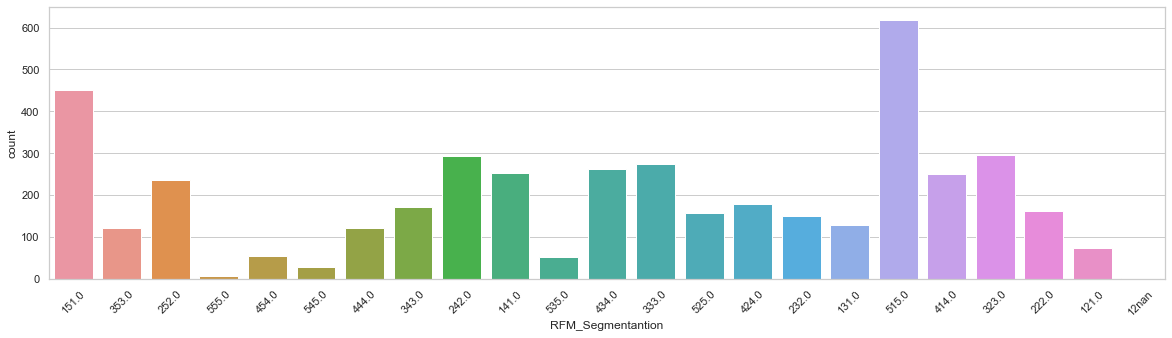

In [62]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(20, 5))

#plot count of each RFM segment
sns.countplot(x="RFM_Segmentantion", data=rfm)
plt.xticks(rotation=45)

plt.show()

In [63]:
# Create a new column accordingly to the customers score 

def rank(a):
    
    if  (a >= 0) & (a <= 3):
        return 'Basic'
    
    elif (a <=7):
        return 'Advanced'
    
    elif (a <= 13):
        return 'Gold'
    else:
        return 'Platinum'

In [64]:
rfm['Rank_id'] = rfm['RFM_Score'].apply(rank)
rfm.head(10).reset_index()

,index,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segmentantion,Rank_id
0,326,12748,1,210,1.0,1,5,1,7,151.0,Advanced
1,1879,14911,2,201,2.0,1,5,1,7,151.0,Advanced
2,4010,17841,2,123,2.0,1,5,1,7,151.0,Advanced
3,562,13089,3,97,3.0,1,5,1,7,151.0,Advanced
4,1661,14606,2,93,2.0,1,5,1,7,151.0,Advanced
5,2176,15311,1,91,1.0,1,5,1,7,151.0,Advanced
6,481,12971,4,86,4.0,1,5,1,7,151.0,Advanced
7,1689,14646,2,74,2.0,1,5,1,7,151.0,Advanced
8,2702,16029,39,63,39.0,3,5,3,11,353.0,Gold
9,796,13408,2,62,2.0,1,5,1,7,151.0,Advanced


In [65]:
# VIZOUALAZATION ANALOGA TON RANK TOUS EDW 

In [66]:
# We can underastand better the clients by the rank 

ranks = rfm['Rank_id'].value_counts()
ranks

Gold        3083
Advanced    1218
Platinum      35
Basic          1
Name: Rank_id, dtype: int64

In [67]:
rfm_new = rfm_new.drop(['customer_id'], axis = 1)
rfm_new.head()

,recency,frequency,monetary
326,1,210,1.0
1879,2,201,2.0
4010,2,123,2.0
562,3,97,3.0
1661,2,93,2.0


In [68]:
rfm_new.dropna(inplace = True)
rfm_new.isnull().sum()

recency      0
frequency    0
monetary     0
dtype: int64

In [69]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_new)

KMeans(max_iter=50, n_clusters=4)

In [70]:
kmeans.labels_

array([3, 3, 3, ..., 3, 3, 3])

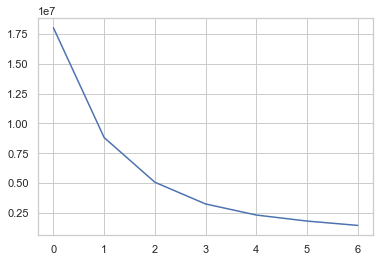

In [71]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_new)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [72]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_new)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_new, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.736119282440422
For n_clusters=3, the silhouette score is 0.6689426598282577
For n_clusters=4, the silhouette score is 0.6051045321115178
For n_clusters=5, the silhouette score is 0.6030287168141112
For n_clusters=6, the silhouette score is 0.5840840946961425
For n_clusters=7, the silhouette score is 0.5330610679497987
For n_clusters=8, the silhouette score is 0.5326551920827253


In [73]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_new)

KMeans(max_iter=50, n_clusters=3)

In [74]:
# assign the label
rfm_new['Cluster_Id'] = kmeans.labels_
rfm_new.head()

,recency,frequency,monetary,Cluster_Id
326,1,210,1.0,0
1879,2,201,2.0,0
4010,2,123,2.0,0
562,3,97,3.0,0
1661,2,93,2.0,0


In [75]:
end = time.time()
time = end - start 
time1 = round(time, 2)
print('The project executed only in', time1 , 'seconds')

The project executed only in 16.57 seconds
